In [ ]:
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller,kpss

from sklearn.preprocessing import MinMaxScaler
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



In [ ]:
df = pd.read_csv('./cleaned_data.csv')
df.plot(x='date', y='close')

In [49]:
# df['close'] = np.log(df['close'])
# df.plot(x='date', y='close')

In [ ]:
# result = adfuller(df['close'])
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])

In [ ]:
def adf_test(target_series):
    """
    Parameters
    ----------
    target_series : Pandas Series
        The column of dataframe that contains the target data to which
        we want to test for stationarity e.g. Bitcoin Price.
    Returns
    -------
    adf_statistic : Float
        The adf statistic.
    p_value : Float
        The p value of the adf test.
    """
    result = adfuller(target_series)
    adf_statistic = result[0]
    p_value = result[1]
    print('ADF Statistic: %f' % adf_statistic)
    print('p-value: %f' % p_value)
    print(result)
    return adf_statistic, p_value

def kpss_test(target_series):
    print("Results of KPSS Test:")
    kpsstest = kpss(target_series, regression="ct", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

def find_order_of_differencing(df):
    """
    Parameters
    ----------
    df : DataFrame
        cleaned time series data of the respective currency.
    Returns
    -------
    d : INT
        An integar representing the number of differences to get time
        series stationary. When P value is < 0.05 from augmented
        dicky fuller test function will return d.
    """
    # get the adf statistic and p values
    adf_statistic, p_value = adf_test(df['close'])
    # get kpss statiostic and p value
#     kpss_test(df['close'])
    # p value needs to be < 0.05 for time series to be stationary
    if p_value > 0.05:
        # set number of differences to 0
        d = 0
        # if p value is above threshold repeatedly run logic until below
        while p_value > 0.05:
            print("")
            print("")
            print("P value to large, trying differencing")
            # difference the time series
            df['close'] = df['close'].diff()
            # drop the null values
            df.dropna(inplace = True)
            # add 1 to d for each iteration to represent 1 differencing
            d += 1
            # perform adf test again to asses p value and exit loop if stationary
            adf_statistic, p_value = adf_test(df['close'])
            # perform KPSS test
#             kpss_test(df['close'])
        print(f"Success... TS now stationary after {d} differncing")
        return d, df

In [38]:
# d, df = find_order_of_differencing(df)

ADF Statistic: -1.008435
p-value: 0.750176
(-1.0084345662811767, 0.750175569055259, 49, 41227, {'1%': -3.430508626802995, '5%': -2.861610109460384, '10%': -2.566807317004268}, 559976.7469266625)


P value to large, trying differencing
ADF Statistic: -30.568469
p-value: 0.000000
(-30.568469215893572, 0.0, 48, 41227, {'1%': -3.430508626802995, '5%': -2.861610109460384, '10%': -2.566807317004268}, 559962.7754830994)
Success... TS now stationary after 1 differncing


In [ ]:
# df.plot(x='date', y='close')

In [ ]:
# plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':120})
# fig, axes = plt.subplots(2, 2, sharex=False)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
# axes[0, 0].plot(train_normalized)
# axes[0, 0].set_title('Original Series')
# plot_acf(train_normalized, ax=axes[0, 1], lags=30)


# # 1st Differencing
# axes[1, 0].plot(np.diff(train_normalized))
# axes[1, 0].set_title('1st Order Differencing')
# plot_acf(np.diff(train_normalized), ax=axes[1, 1],lags=30)
# plot_pacf(df['close'], lags=30)

In [ ]:
# plot_acf(df['close'], lags=30)

In [ ]:
# fh = int(len(df)/2)
# print(df['close'][:fh].describe())
# print(df['close'][fh:].describe())

In [ ]:
# fig, ax = plt.subplots(1, figsize =(12,8), dpi=100)
# df['close'][fh:].hist()
# df['close'][:fh].hist()

In [ ]:
# sm.stats.acorr_ljungbox(df['close'], lags=30)

In [50]:
def auto_arima(orig_df):
    """
    Parameters
    ----------
    orig_df : Data Frame
        Copied data frame from origonal read in prior to manual differencing.
    Returns
    -------
    model.order: Tuple
        tuple of found p,q,q values from auto arima
    differenced_by_auto_arima: Data Frame
        the differenced data frame output from the auto arima function
    fitted_residuals: The residuals of the fitted model.
    """
    #get target series
    orig_df = np.log(orig_df['close'])
    model = pm.auto_arima(orig_df,
                          start_p=10,
                          start_q=10,
                          test='adf',
                          max_p=10, 
                          max_q=10, 
                          m=1,
                          d=None,           
                          seasonal=False,   
                          D=0, 
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True,
                         stepwise = True)
    # difference df by d found by auto arima
    differenced_by_auto_arima = orig_df.diff(model.order[1])
    return model.order, differenced_by_auto_arima, model.resid()

In [1]:
model_order, differenced_data, model_residuals = auto_arima(df)

In [61]:
threshold = -20
model = sm.tsa.arima.ARIMA(np.log(df['close'][:threshold]), order = (6,1,9), seasonal_order=(0, 0, 0, 24))

In [62]:
fitted = model.fit()

C:\Users\Athra\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [63]:
fc = fitted.get_forecast(-threshold)
fc = (fc.summary_frame(alpha=0.05))
fc_mean = fc['mean']
fc_lower = fc['mean_ci_lower']
fc_upper = fc['mean_ci_upper']

fc['exp'] = np.exp(fc['mean'])
fc['org'] = df['close'][threshold:]
fc

close,mean,mean_se,mean_ci_lower,mean_ci_upper,exp,org
41257,10.570056,0.009310,10.551810,10.588302,38950.855819,39008.71
41258,10.569707,0.012819,10.544582,10.594832,38937.268882,38926.11
41259,10.569564,0.015376,10.539429,10.599700,38931.712245,38881.47
41260,10.569335,0.017549,10.534939,10.603730,38922.769540,38922.16
41261,10.569254,0.019383,10.531265,10.607243,38919.627238,38780.01
41262,10.569113,0.021016,10.527922,10.610303,38914.129537,38711.88
41263,10.569181,0.022474,10.525132,10.613229,38916.770079,38528.77
41264,10.569248,0.023825,10.522552,10.615944,38919.383458,38500.41
41265,10.569333,0.025103,10.520131,10.618535,38922.711746,38910.00
41266,10.569525,0.026316,10.517945,10.621104,38930.170156,38840.00


<AxesSubplot:>

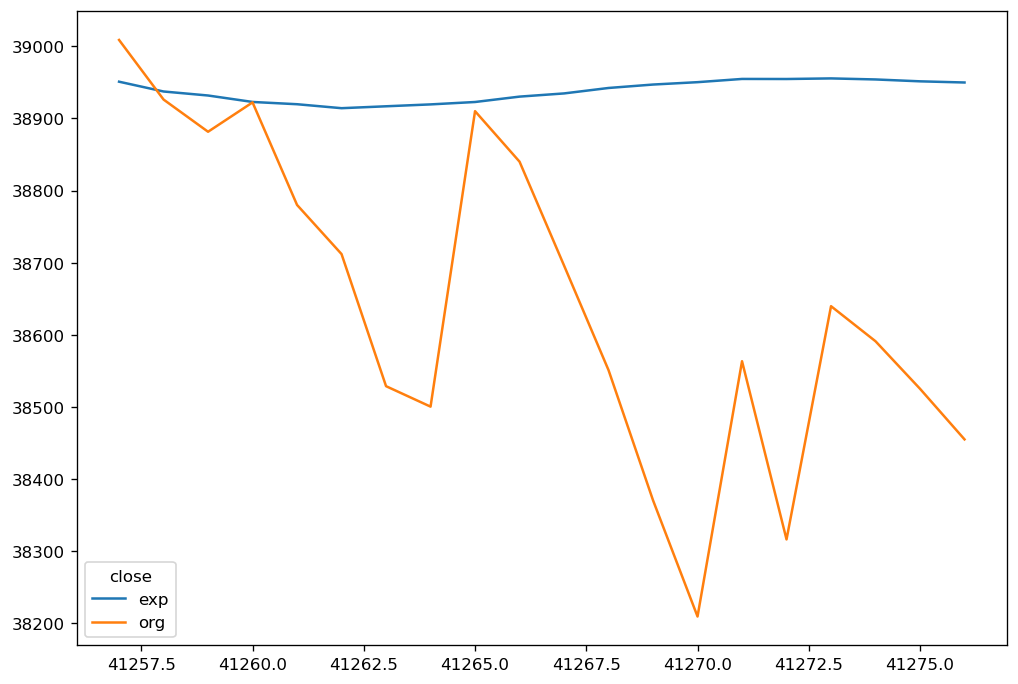

In [64]:
fc.plot(y=['exp', 'org'], use_index = True)